<a href="https://colab.research.google.com/github/Samuel-K95/Tanzania-Tourism-Prediction/blob/main/Tanzania_tourism_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
alfredkondoro_tanzania_tourism_prediction_zindi_africa_path = kagglehub.dataset_download('alfredkondoro/tanzania-tourism-prediction-zindi-africa')

print('Data source import complete.')


100%|██████████| 120k/120k [00:00<00:00, 37.1MB/s]

Extracting files...
Data source import complete.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip -q --disable-pip-version-check install mplcyberpunk
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns

import mplcyberpunk
plt.style.use('cyberpunk')
from termcolor import colored

In [6]:
PATH = "/content/drive/MyDrive/Tanzania Tourism"

In [7]:
train = pd.read_csv(PATH+"/Train.csv")
test = pd.read_csv(PATH+"/Test.csv")
ss = pd.read_csv(PATH+"/SampleSubmission.csv")
vd = pd.read_csv(PATH+"/VariableDefinitions.csv")


normalized_min_max = np.log1p(train['total_cost'])
train['total_cost'] = normalized_min_max

In [8]:
train[train['travel_with'] == 'Alone']

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,15.013968
6,tour_1007,SOUTH AFRICA,45-64,Alone,0.0,1.0,Business,Mountain climbing,"Friends, relatives",Independent,...,No,No,No,No,9.0,0.0,Cash,Yes,Friendly People,13.052243
8,tour_101,NIGERIA,25-44,Alone,0.0,1.0,Leisure and Holidays,Cultural tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,4.0,0.0,Cash,Yes,NaN,13.809996
9,tour_1011,INDIA,25-44,Alone,1.0,0.0,Business,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,5.0,0.0,Credit Card,Yes,Friendly People,14.726287
14,tour_1018,MOZAMBIQUE,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Beach tourism,"Friends, relatives",Independent,...,No,No,No,No,2.0,0.0,Cash,Yes,Wildlife,13.116850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,tour_982,THAILAND,25-44,Alone,1.0,0.0,Meetings and Conference,Mountain climbing,others,Independent,...,No,No,No,No,5.0,0.0,Cash,Yes,Friendly People,12.934529
4796,tour_983,SOUTH AFRICA,25-44,Alone,0.0,1.0,Meetings and Conference,Mountain climbing,"Travel, agent, tour operator",Independent,...,No,No,No,No,3.0,0.0,Cash,Yes,Friendly People,14.320822
4797,tour_984,UNITED KINGDOM,25-44,Alone,1.0,0.0,Leisure and Holidays,Beach tourism,"Friends, relatives",Independent,...,No,No,No,No,3.0,0.0,Credit Card,Yes,Friendly People,15.331095
4799,tour_986,UNITED STATES OF AMERICA,65+,Alone,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,19.0,0.0,Cash,Yes,Wildlife,16.718716


In [9]:
columns = vd['Column Name'].unique()
train_cols = train.columns

In [10]:
vd = vd.set_index('Column Name')

In [11]:
for i in range(len(columns)):
  column = columns[i]
  print(column,':', vd.loc[column, 'Definition'])

id : Unique identifier for each tourist
country : The country a tourist coming  from.
age_group : The age group of a tourist.
travel_with : The relation of people a tourist travel with to Tanzania
total_female : Total number of females
total_male : Total number of males
purpose : The purpose of visiting  Tanzania
main_activity : The main activity of tourism in Tanzania
infor_source : The source of information about tourism in Tanzania
tour_arrangment : The arrangment of visiting Tanzania
package_transport_int : If the tour package include international transportation service
package_accomodation : If the tour package include accommodation service
package_food : If the tour package include food service
package_transport_tz : If the tour package include transport service within Tanzania 
package_sightseeing : If the tour package include sightseeing service
package_guided_tour : If the tour package include tour guide
package_insurance : if the tour package include insurance service
night_

In [12]:
sm = train.groupby('payment_mode')['total_cost'].mean()
train['payment_mode'].value_counts()
pay_mp = {
    'Cash': 1,
    'Credit Card': 2,
    'Other': 3,
    'Travellers Cheque': 4
}
train['payment_mode_mp'] = train['payment_mode'].map(pay_mp)
test['payment_mode_mp'] = test['payment_mode'].map(pay_mp)
train['total_cost'].corr(train['payment_mode_mp'])

0.11944535031158422

In [13]:
# tries to find cells where the total_female + total_male == 1 which indicates that person was alone.
# We could use this information to fill the areas with the above specified condition to 1
train.loc[(train['travel_with'].isna()) & (train['total_female'] + train['total_male'] == 1), 'travel_with'] = 'Alone'
train['travel_with'].isna().sum()

29

In [14]:
train['most_impressing'].value_counts()

,count
most_impressing,
Friendly People,1541
Wildlife,1038
No comments,743
"Wonderful Country, Landscape, Nature",507
Good service,365
Excellent Experience,271
Satisfies and Hope Come Back,31


In [15]:
train.dropna(subset=['most_impressing'],axis=0, inplace=True)

Missing values column-wise:
travel_with     25
total_female     3
total_male       4
Name: Missing Values, dtype: int64


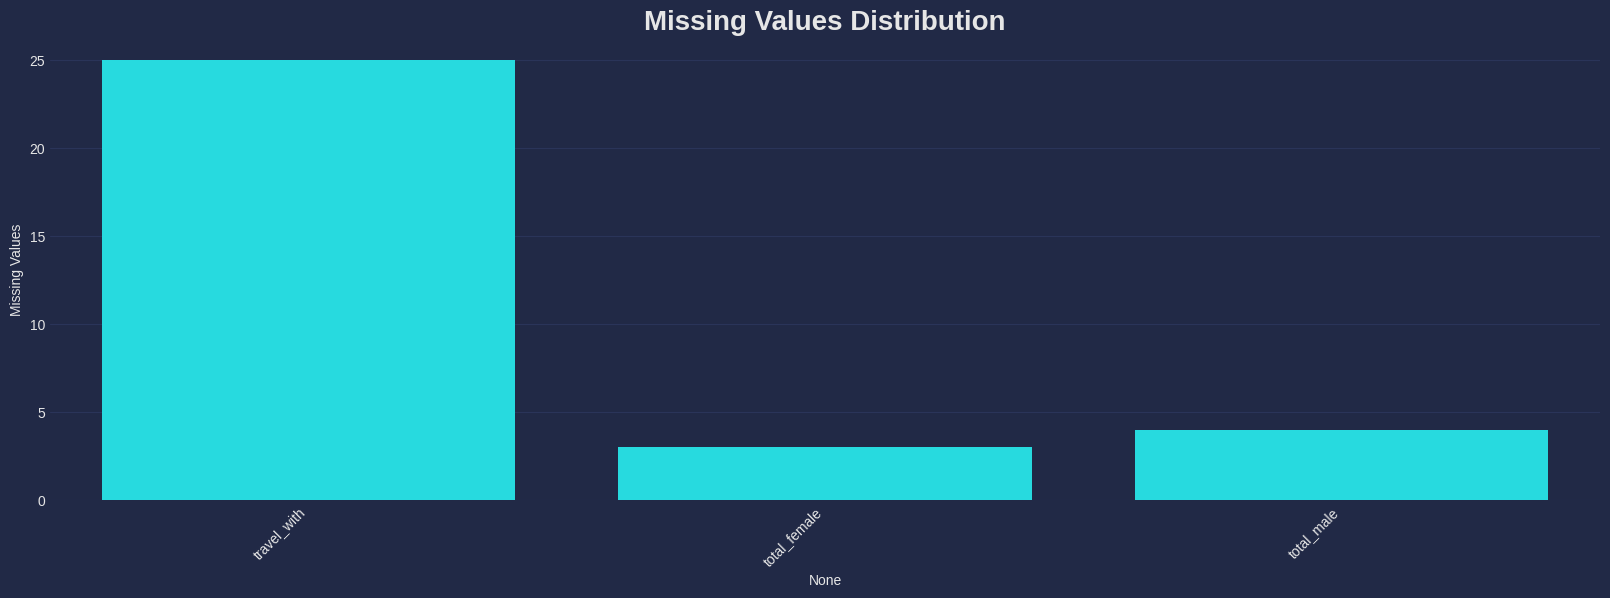

In [16]:
na = pd.DataFrame(train.isna().sum(), columns=['Missing Values'])
na = na[na['Missing Values'] > 0]
plt.figure(figsize=(20, 6))
sns.barplot(y=na['Missing Values'], x=na.index)
plt.title('Missing Values Distribution', size=20, weight='bold')
plt.xticks(rotation=45, ha='right')

print(colored("Missing values column-wise:", 'magenta'))
print(colored(na['Missing Values'], 'magenta'))

plt.show()

In [17]:
fe = []; cat_fe = []; no_fe = []
categorical_features = []
numerical_features = []
for i in train.columns[1:]:
  if train[i].dtype == 'O':
    categorical_features.append(i)
  else:
    numerical_features.append(i)
  if train[i].isnull().sum() < 2000:
    fe.append(i)
    if train[i].dtype == 'O':
      cat_fe.append(i)
      print("There are "+ str(len(train[i].value_counts())) + " in " + str(i))
  else:
    no_fe.append(i)

print ('----------------------------------')
print(str(len(fe)))
print(str(len(cat_fe)))
print(str(len(no_fe)))


print('categorical features are: ', categorical_features)
for category in categorical_features:
  print(category, train[category].dtype)
print('numerical features are: ', numerical_features)
for num in numerical_features:
  print(num, train[num].dtype)



There are 103 in country
There are 4 in age_group
There are 5 in travel_with
There are 7 in purpose
There are 9 in main_activity
There are 8 in info_source
There are 2 in tour_arrangement
There are 2 in package_transport_int
There are 2 in package_accomodation
There are 2 in package_food
There are 2 in package_transport_tz
There are 2 in package_sightseeing
There are 2 in package_guided_tour
There are 2 in package_insurance
There are 4 in payment_mode
There are 2 in first_trip_tz
There are 7 in most_impressing
----------------------------------
23
17
0
categorical features are:  ['country', 'age_group', 'travel_with', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance', 'payment_mode', 'first_trip_tz', 'most_impressing']
country object
age_group object
travel_with object
purpose object
main_activity object
info_source obje

In [18]:
packages = ['package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance']

In [19]:
train[packages].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4496 entries, 0 to 4808
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   package_transport_int  4496 non-null   object
 1   package_accomodation   4496 non-null   object
 2   package_food           4496 non-null   object
 3   package_transport_tz   4496 non-null   object
 4   package_sightseeing    4496 non-null   object
 5   package_guided_tour    4496 non-null   object
 6   package_insurance      4496 non-null   object
dtypes: object(7)
memory usage: 281.0+ KB


In [20]:
# This block tries to manipulate the packages columns to change it to numeric data
# It adds the number of packages a user buys.

use_package = (
    (train['package_transport_int'] == 'Yes') |
    (train['package_accomodation'] == 'Yes') |
    (train['package_food'] == 'Yes') |
    (train['package_transport_tz'] == 'Yes') |
    (train['package_sightseeing'] == 'Yes') |
    (train['package_guided_tour'] == 'Yes') |
    (train['package_insurance'] == 'Yes')
)

train['cnt_package'] = (
    (train['package_transport_int'] == 'Yes').astype(int) +
    (train['package_accomodation'] == 'Yes').astype(int) +
    (train['package_food'] == 'Yes').astype(int) +
    (train['package_transport_tz'] == 'Yes').astype(int) +
    (train['package_sightseeing'] == 'Yes').astype(int) +
    (train['package_guided_tour'] == 'Yes').astype(int) +
    (train['package_insurance'] == 'Yes').astype(int) +
    (train['tour_arrangement'] == 'Package Tour').astype(int)
)

test['cnt_package'] =  (
    (test['package_transport_int'] == 'Yes').astype(int) +
    (test['package_accomodation'] == 'Yes').astype(int) +
    (test['package_food'] == 'Yes').astype(int) +
    (test['package_transport_tz'] == 'Yes').astype(int) +
    (test['package_sightseeing'] == 'Yes').astype(int) +
    (test['package_guided_tour'] == 'Yes').astype(int) +
    (test['package_insurance'] == 'Yes').astype(int) +
    (test['tour_arrangement'] == 'Package Tour').astype(int)
)
train['cnt_package'].value_counts()
train['total_cost'].corr(train['cnt_package'])
numerical_features.append('cnt_package')

In [21]:
## this block tries to add a new feature, total people by adding the total_female and total_male
## first let's check if there are any missing values

# train['total_female'].isna().sum()  ==> 3
# train['total_male'].isna().sum() ==> 5

# since the values are very small, we can fill them with 0
train['total_female'] = train['total_female'].fillna(0)
train['total_male'] = train['total_male'].fillna(0)

test['total_female'] = test['total_female'].fillna(0)
test['total_male'] = test['total_male'].fillna(0)

test['total_people'] = test['total_female'] + test['total_male']

train['total_people'] = train['total_female'] + train['total_male']

train['total_package'] = train['cnt_package'] * train['total_people']
test['total_package'] = test['cnt_package'] * test['total_people']
train['total_people'].value_counts()
numerical_features.append('total_people')

In [22]:
## this block tries to add a new feature, total_night by adding the night_main_land and night_zanzibar
# first let's check if there are any missing values

# train['night_mainland'].isna().sum() ==> 0
# train['night_zanzibar'].isna().sum()  ==> 0

train['total_night'] = train['night_mainland'] + train['night_zanzibar']
numerical_features.append('total_night')

test['total_night'] = test['night_mainland'] + test['night_zanzibar']

In [23]:
train['country'].value_counts()

,count
country,
UNITED STATES OF AMERICA,681
UNITED KINGDOM,505
ITALY,379
FRANCE,270
KENYA,228
...,...
MYANMAR,1
DOMINICA,1
TUNISIA,1


In [24]:
country_cost_avg = train.groupby('country')['total_cost'].mean().sort_values(ascending=False)
train['total_cost'].corr(country_cost_avg)

nan

In [25]:
train['age_group'].value_counts()

,count
age_group,
25-44,2290
45-64,1316
1-24,590
65+,300


In [26]:
## next let us change the age_group column, since it is categorical we will encode it to numerical value.

# check for missing values
# train['age_group'].isna().sum() ==> 0

mp = {'1-24' : 2, '25-44': 4, '45-64': 3, '65+': 1}
train['age_group_mp'] = train['age_group'].map(mp)
test['age_group_mp'] = test['age_group'].map(mp)
train['total_cost'].corr(train['age_group_mp'])
numerical_features.append('age_group_mp')

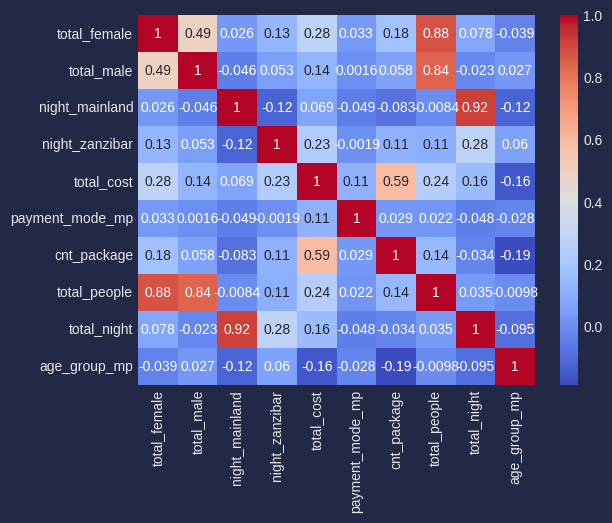

In [27]:
numericals = train[numerical_features]
ax = sns.heatmap(numericals.corr(), annot=True, cmap='coolwarm')
plt.show()

In [28]:
train['purpose'].value_counts()

,count
purpose,
Leisure and Holidays,2756
Visiting Friends and Relatives,571
Business,563
Meetings and Conference,286
Volunteering,134
Other,102
Scientific and Academic,84


In [29]:
train['tour_arrangement'].value_counts()

,count
tour_arrangement,
Independent,2325
Package Tour,2171


In [43]:
relevant = ['country', 'purpose', 'total_people', 'total_night', 'age_group', 'main_activity', 'cnt_package']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(train[relevant], train['total_cost'], test_size = 0.18, random_state = 3, shuffle = True)

In [45]:
X_train.isna().sum()
for feature in list(relevant):
    X_train[feature] = X_train[feature].astype(str)
    X_test[feature] = X_test[feature].astype(str)
    test[feature] = test[feature].astype(str)

In [46]:
train_dataset = Pool(data = X_train, label = y_train, cat_features=list(relevant))
test_dataset = Pool(data = X_test, label = y_test, cat_features=list(relevant))

In [47]:
cmod = CatBoostRegressor(iterations = 30000,
                                   learning_rate=0.01,
                                  random_seed = 3, verbose = 500,
                         )
cmod.fit(train_dataset, eval_set = test_dataset, early_stopping_rounds = 300, use_best_model = True)

0:	learn: 1.6723119	test: 1.6243951	best: 1.6243951 (0)	total: 23.4ms	remaining: 11m 43s
500:	learn: 1.0684261	test: 1.1534041	best: 1.1534041 (500)	total: 3.39s	remaining: 3m 19s
1000:	learn: 1.0339960	test: 1.1508278	best: 1.1507997 (999)	total: 8.3s	remaining: 4m
1500:	learn: 1.0108287	test: 1.1489882	best: 1.1489882 (1500)	total: 11.3s	remaining: 3m 35s
2000:	learn: 0.9840363	test: 1.1464813	best: 1.1464813 (2000)	total: 14.5s	remaining: 3m 22s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 1.146396552
bestIteration = 2010

Shrink model to first 2011 iterations.


In [48]:
testc = cmod.predict(X_test)
returned_pred = np.expm1(testc)
mean_absolute_error(y_test, returned_pred)

5407293.4088146305

In [49]:
mainc = cmod.predict(test[relevant].fillna(''))
returned_pred = np.expm1x(mainc)
returned_pred

array([18185459.58153415, 11317138.41676139,  6620445.89628911, ...,
        2262179.48819545,  1884407.33346484,  3454868.96091497])

In [50]:
ss['total_cost'] = mainc

In [51]:
ss.to_csv(PATH+'/base_four.csv', index=False)